

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation/data
* https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* https://amaarora.github.io/posts/2020-09-13-unet.html
* https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
* https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8
* https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
* https://huggingface.co/docs/transformers/model_doc/segformer
* https://www.kaggle.com/code/damianpanek/segformerb0-people-clothing-segmentation

1\. Обсудите постановку задачи сегментации изображений.

2\. Рассмотрите пример работы слоя `ConvTranspose2d`.

In [1]:
import torch
import torch.nn as nn

In [2]:
img = torch.arange(0, 4).reshape(1, 1, 2, 2).float()
img

tensor([[[[0., 1.],
          [2., 3.]]]])

In [3]:
layer = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    bias=False,
)

layer(img)

tensor([[[[ 0.0000, -0.1692,  0.2171, -0.2942],
          [-0.3385, -0.2588,  0.2756, -0.9209],
          [-0.3707,  0.1224,  0.7407,  0.1585],
          [ 0.5060,  1.1180,  1.0858,  0.8211]]]],
       grad_fn=<ConvolutionBackward0>)

In [4]:
res = torch.zeros(4, 4)
w = layer.weight.squeeze()
x = img.squeeze()

res[:3, :3] += w * x[0, 0]
res[:3, 1:4] += w * x[0, 1]
res[1:4, :3] += w * x[1, 0]
res[1:4, 1:4] += w * x[1, 1]
res

tensor([[ 0.0000, -0.1692,  0.2171, -0.2942],
        [-0.3385, -0.2588,  0.2756, -0.9209],
        [-0.3707,  0.1224,  0.7407,  0.1585],
        [ 0.5060,  1.1180,  1.0858,  0.8211]], grad_fn=<CopySlices>)

<p class="task" id="1"></p>

1\. Опишите датасет `ClothesSegmentationDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал два элемента: тензор с изображением и тензор с маской. Маска должна быть представлена трехмерным тензором целых чисел. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений и масок. Создайте объект датасета и выведите на экран форму и типы одного изображения и его маски.

- [ ] Проверено на семинаре

In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as F
from torchvision.transforms import Compose
import numpy as np
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
import matplotlib.pyplot as plt

In [6]:
class ClothesSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        
        if self.image_transform:
            image = self.image_transform(image)
        else:
            image = F.to_tensor(image)  

        
        mask = np.array(mask, dtype=np.int64)  

        if self.mask_transform:
            mask = Image.fromarray(mask.astype(np.uint8))  
            mask = self.mask_transform(mask)  
            mask = torch.from_numpy(np.array(mask))  
        else:
            mask = torch.from_numpy(mask).long()  

        
        if mask.ndim == 2:
            mask = mask.unsqueeze(0)  

        return image, mask

In [7]:
image_dir = "./Clothes/jpeg_images/IMAGES"  
mask_dir = "./Clothes/jpeg_masks/MASKS"    

image_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = Compose([
    Resize((256, 256))
])

dataset = ClothesSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, 
                                     image_transform=image_transform, mask_transform=mask_transform)


In [8]:
image, mask = dataset[0]

print(f"Image shape: {image.shape}, dtype: {image.dtype}")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")

Image shape: torch.Size([3, 256, 256]), dtype: torch.float32
Mask shape: torch.Size([1, 256, 256]), dtype: torch.uint8


<p class="task" id="2"></p>

2\. Напишите функцию `show_image_with_mask`, которая выводит рядом два изображения: фотографию и маску. Продемонстрируйте работу функции, взяв один пример из созданного датасета.

- [ ] Проверено на семинаре

In [9]:
def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def show_image_with_mask(image, mask):  
    mean = [0.485, 0.456, 0.406]  
    std = [0.229, 0.224, 0.225]
    image = denormalize(image, mean, std).clamp(0, 1)  

    
    image_np = image.permute(1, 2, 0).cpu().numpy()  
    mask_np = mask[0].cpu().numpy()  

    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    
    axes[0].imshow(image_np)
    axes[0].set_title("Image")
    axes[0].axis("off")
    
    
    axes[1].imshow(mask_np, cmap="nipy_spectral", vmin=0, vmax=59)
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    
    plt.tight_layout()
    plt.show()

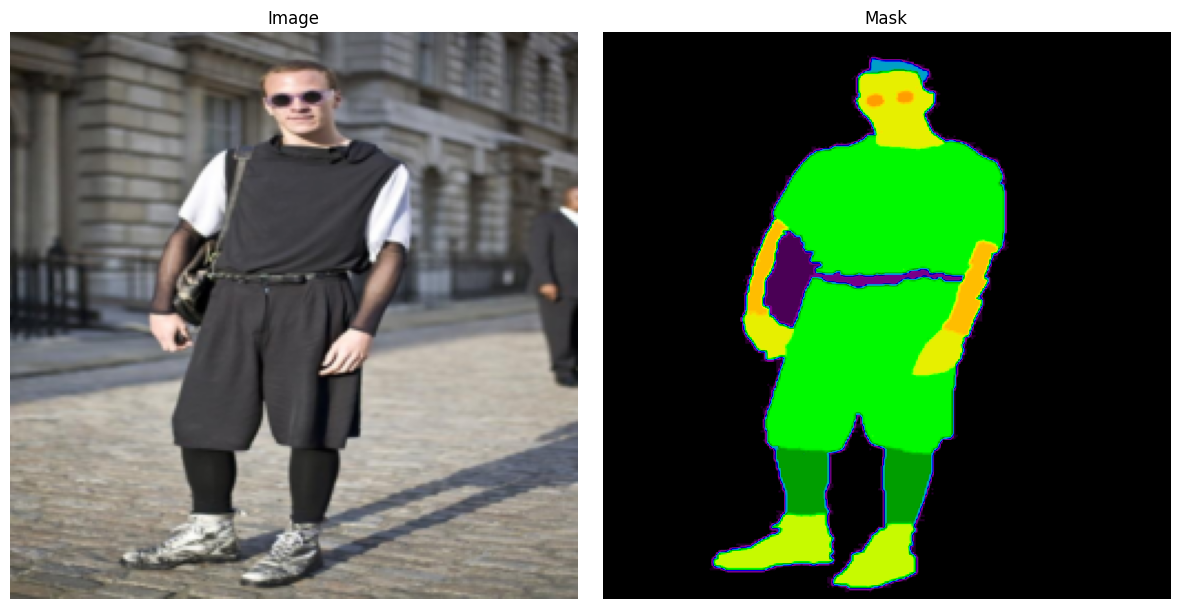

In [10]:
image, mask = dataset[-1]

show_image_with_mask(image, mask)

<p class="task" id="3"></p>

3\. Реализуйте архитектуру U-Net. Реализуйте модель таким образом, чтобы на выходе для каждого изображения получался тензор размера `n_classes x h x w`, где `n_classes` - количество уникальных значений в масках, а `h` и `w` - размер исходного изображения. Возьмите один пример из набора данных и пропустите его через сеть. Выведите форму полученного результата на экран.

- [ ] Проверено на семинаре

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)
        
        self.bottleneck = conv_block(512, 1024)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)
        
        self.output = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2))
        
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2))
        
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.decoder4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.decoder3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.decoder1(d1)
        
        out = self.output(d1)
        return out


In [12]:
model = UNet(in_channels=3, n_classes=59)

image, mask = dataset[32]  
image = image.unsqueeze(0)  

output = model(image)

print(f"Input image shape: {image.shape}")  
print(f"Output shape: {output.shape}")    

Input image shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 59, 256, 256])


<p class="task" id="4"></p>

4\.  Разбейте набор данных на обучающее и валидационное множество. Обучите модель U-Net для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Обратите внимание, что выборка является несбалансированной. При расчете функции потерь примените любую известную вам технику для работы с несбалансированными выборками.

При создании датасета допускается использовать преобразования, уменьшающие размер изображений (для ускорения процесса обучения).

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [13]:
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

image_transform = Compose([
    Resize((128, 128)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = Compose([
    Resize((128, 128))
])

dataset = ClothesSegmentationDataset(
    image_dir="./Clothes/jpeg_images/IMAGES",
    mask_dir="./Clothes/jpeg_masks/MASKS",
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

class IoULoss(nn.Module):
    def __init__(self, n_classes, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.n_classes = n_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)  

        
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.n_classes)  
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)  

        return 1 - iou.mean()

class DiceLoss(nn.Module):
    def __init__(self, n_classes, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)  

        
        targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=self.n_classes)  
        targets_one_hot = targets_one_hot.permute(0, 3, 1, 2).float()  

        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        dice = (2 * intersection + self.smooth) / (preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3)) + self.smooth)  

        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, n_classes, weight_ce=1.0, weight_iou=1.0, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.ce = nn.CrossEntropyLoss()
        self.iou = IoULoss(n_classes, smooth)
        self.weight_ce = weight_ce
        self.weight_iou = weight_iou

    def forward(self, preds, targets):
        loss_ce = self.ce(preds, targets)
        loss_iou = self.iou(preds, targets)
        return self.weight_ce * loss_ce + self.weight_iou * loss_iou

In [ ]:
n_classes = 59


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, n_classes=n_classes).to(device)


criterion = CombinedLoss(n_classes=n_classes, weight_ce=1.0, weight_iou=1.0)  

optimizer = optim.AdamW(model.parameters(), lr=1e-4)


num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))  
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(1))  
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

Epoch 1/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.27it/s]


Epoch 1/20
Train Loss: 3.3336
Val Loss: 2.2957


Epoch 2/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.22it/s]


Epoch 2/20
Train Loss: 2.1751
Val Loss: 2.1043


Epoch 3/20 - Validation: 100%|██████████| 25/25 [00:00<00:00, 25.11it/s]


Epoch 3/20
Train Loss: 2.0783
Val Loss: 2.0695


Epoch 4/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.51it/s]


Epoch 4/20
Train Loss: 2.0274
Val Loss: 2.0188


Epoch 5/20 - Validation: 100%|██████████| 25/25 [00:00<00:00, 25.02it/s]


Epoch 5/20
Train Loss: 1.9977
Val Loss: 1.9682


Epoch 6/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.58it/s]


Epoch 6/20
Train Loss: 1.9656
Val Loss: 1.9507


Epoch 7/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 24.53it/s]


Epoch 7/20
Train Loss: 1.9348
Val Loss: 1.9231


Epoch 8/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 24.19it/s]


Epoch 8/20
Train Loss: 1.9097
Val Loss: 1.9047


Epoch 9/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 24.44it/s]


Epoch 9/20
Train Loss: 1.8987
Val Loss: 1.8902


Epoch 10/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 24.55it/s]


Epoch 10/20
Train Loss: 1.8776
Val Loss: 1.8792


Epoch 11/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.78it/s]


Epoch 11/20
Train Loss: 1.8628
Val Loss: 1.8618


Epoch 12/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.91it/s]


Epoch 12/20
Train Loss: 1.8477
Val Loss: 1.8537


Epoch 13/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.73it/s]


Epoch 13/20
Train Loss: 1.8417
Val Loss: 1.8322


Epoch 14/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.65it/s]


Epoch 14/20
Train Loss: 1.8281
Val Loss: 1.8258


Epoch 15/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.50it/s]


Epoch 15/20
Train Loss: 1.8172
Val Loss: 1.8131


Epoch 16/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 24.94it/s]


Epoch 16/20
Train Loss: 1.8058
Val Loss: 1.8033


Epoch 17/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.36it/s]


Epoch 17/20
Train Loss: 1.7993
Val Loss: 1.7956


Epoch 18/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 22.96it/s]


Epoch 18/20
Train Loss: 1.7873
Val Loss: 1.7795


Epoch 19/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.88it/s]


Epoch 19/20
Train Loss: 1.7772
Val Loss: 1.7680


Epoch 20/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 23.90it/s]

Epoch 20/20
Train Loss: 1.7651
Val Loss: 1.7724


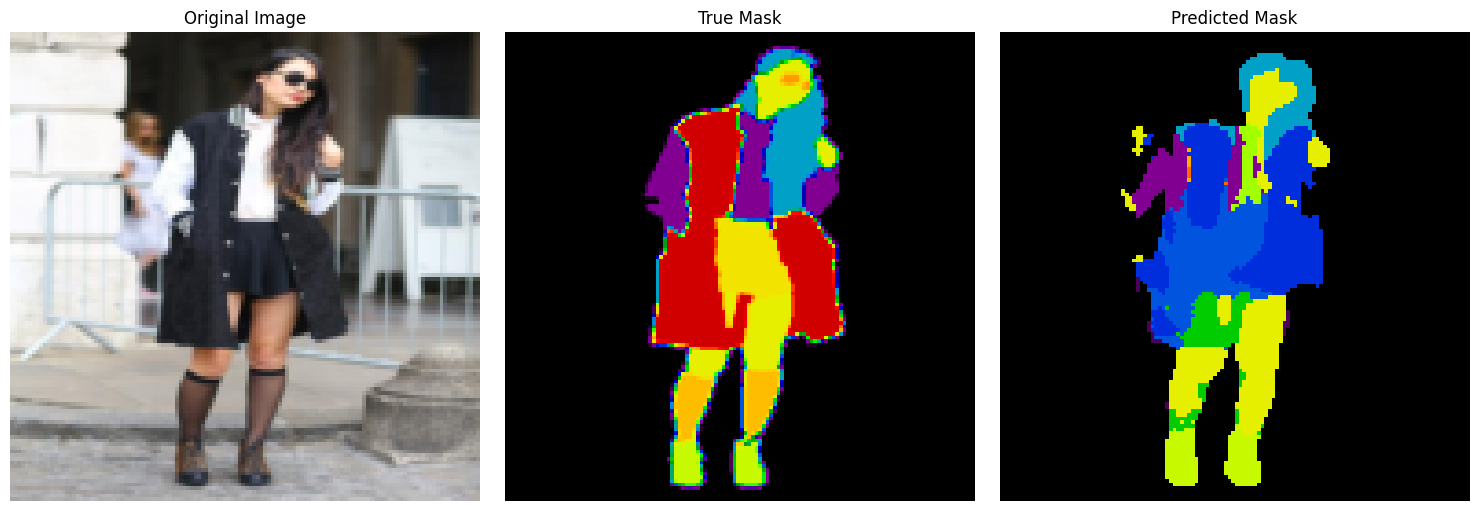

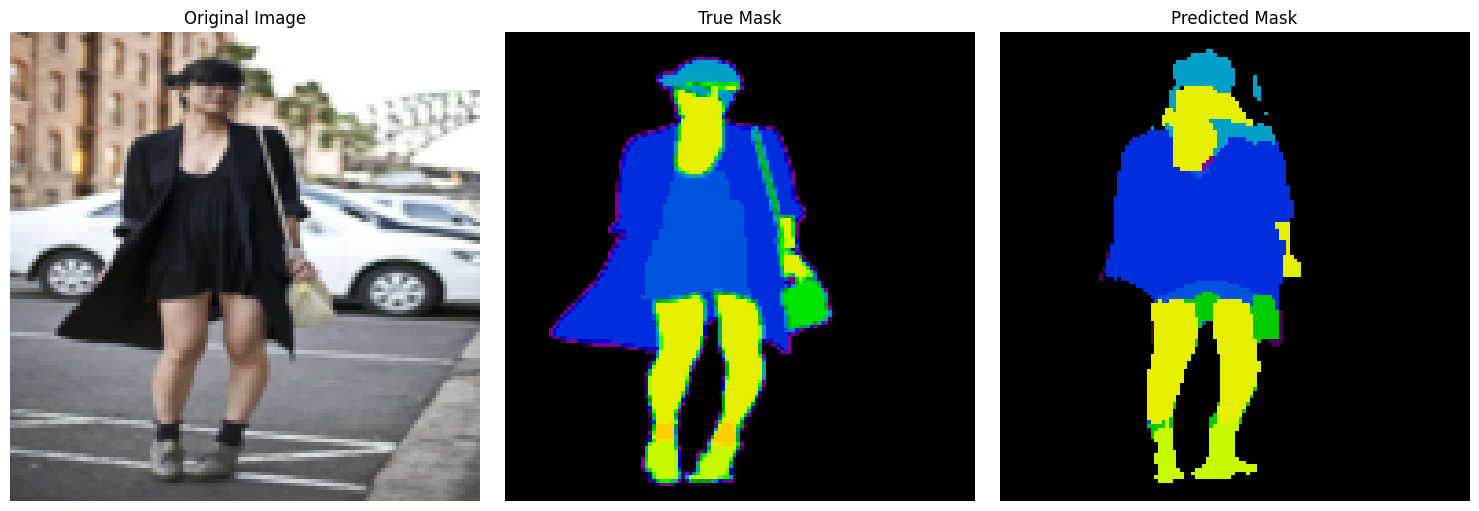

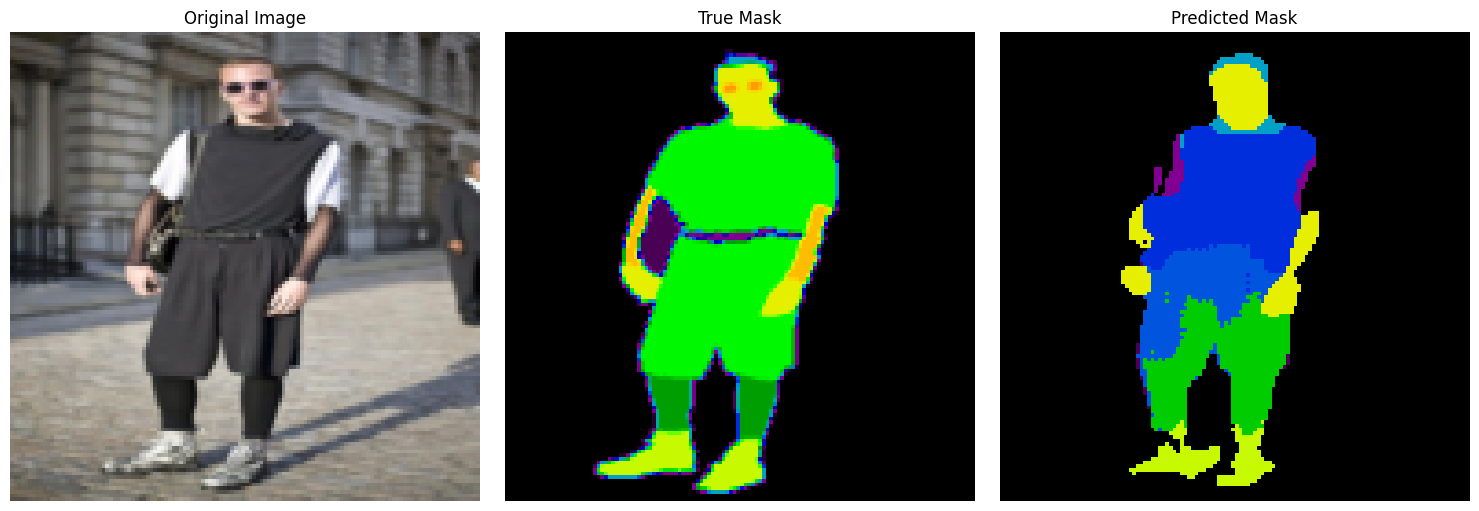

In [15]:
import matplotlib.pyplot as plt
import torch

def denormalize(image, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def visualize_predictions(model, dataset, indices, device, n_classes):
    model.eval() 
    mean = [0.485, 0.456, 0.406]  
    std = [0.229, 0.224, 0.225]   

    for idx in indices:
        image, true_mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)  
        
        with torch.no_grad():
            pred_mask = model(image_tensor)
            pred_mask = torch.argmax(pred_mask, dim=1).squeeze(0).cpu().numpy()

        image_np = denormalize(image, mean, std).permute(1, 2, 0).cpu().numpy()  
        true_mask_np = true_mask.squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(image_np)
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(true_mask_np, cmap="nipy_spectral", vmin=0, vmax=n_classes - 1)
        axes[1].set_title("True Mask")
        axes[1].axis("off")
        
        axes[2].imshow(pred_mask, cmap="nipy_spectral", vmin=0, vmax=n_classes - 1)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")
        
        plt.tight_layout()
        plt.show()

indices = [0, 10, -1]
visualize_predictions(model, dataset, indices, device, n_classes=60)

<p class="task" id="5"></p>

5\.  Обучите модуль `SegformerForSemanticSegmentation` из пакета `transformers` для сегментации изображения. Во время обучения выводите на экран значения функции потерь и точности прогнозов на обучающем и валидационном множестве. Для оптимизации используйте значение функции потерь, которое возвращает вам модель.

Используя обученную модель, получите предсказания для нескольких изображений и отрисуйте их.
- [ ] Проверено на семинаре

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b0-finetuned-ade-512-512" 
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=60,
    ignore_mismatched_sizes=True
).to(device)

processor = SegformerImageProcessor.from_pretrained(model_name)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([60]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([60, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Danya\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\utils\deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [4]:
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor

image_transform = Compose([
    Resize((256, 256)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = Compose([
    Resize((256, 256))
])

dataset = ClothesSegmentationDataset(
    image_dir="C:\\Users\\Danya\\Downloads\\Clothes\\jpeg_images\\IMAGES",
    mask_dir="C:\\Users\\Danya\\Downloads\\Clothes\\jpeg_masks\\MASKS",
    image_transform=image_transform,
    mask_transform=mask_transform
)

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [5]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for pixel_values, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        pixel_values = pixel_values.to(device)
        labels = labels.to(device, dtype=torch.long).squeeze(1)  

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for pixel_values, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            pixel_values = pixel_values.to(device)
            labels = labels.to(device, dtype=torch.long).squeeze(1) 
            outputs = model(pixel_values=pixel_values, labels=labels)
            val_loss += outputs.loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")

Epoch 1/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch 1/20
Train Loss: 3.2411
Val Loss: 2.5312


Epoch 2/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.85it/s]


Epoch 2/20
Train Loss: 2.2211
Val Loss: 1.8509


Epoch 3/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch 3/20
Train Loss: 1.6659
Val Loss: 1.4590


Epoch 4/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch 4/20
Train Loss: 1.3031
Val Loss: 1.1553


Epoch 5/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch 5/20
Train Loss: 1.0838
Val Loss: 1.0037


Epoch 6/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch 6/20
Train Loss: 0.9470
Val Loss: 0.8967


Epoch 7/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]


Epoch 7/20
Train Loss: 0.8593
Val Loss: 0.8325


Epoch 8/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch 8/20
Train Loss: 0.7954
Val Loss: 0.7704


Epoch 9/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch 9/20
Train Loss: 0.7466
Val Loss: 0.7369


Epoch 10/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch 10/20
Train Loss: 0.7072
Val Loss: 0.7082


Epoch 11/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch 11/20
Train Loss: 0.6763
Val Loss: 0.6876


Epoch 12/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 15.99it/s]


Epoch 12/20
Train Loss: 0.6459
Val Loss: 0.6723


Epoch 13/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch 13/20
Train Loss: 0.6227
Val Loss: 0.6565


Epoch 14/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 17.03it/s]


Epoch 14/20
Train Loss: 0.5999
Val Loss: 0.6399


Epoch 15/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch 15/20
Train Loss: 0.5802
Val Loss: 0.6445


Epoch 16/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 17.09it/s]


Epoch 16/20
Train Loss: 0.5604
Val Loss: 0.6165


Epoch 17/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch 17/20
Train Loss: 0.5411
Val Loss: 0.6073


Epoch 18/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.67it/s]


Epoch 18/20
Train Loss: 0.5264
Val Loss: 0.6122


Epoch 19/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch 19/20
Train Loss: 0.5146
Val Loss: 0.6011


Epoch 20/20 - Validation: 100%|██████████| 25/25 [00:01<00:00, 16.86it/s]

Epoch 20/20
Train Loss: 0.4979
Val Loss: 0.5993


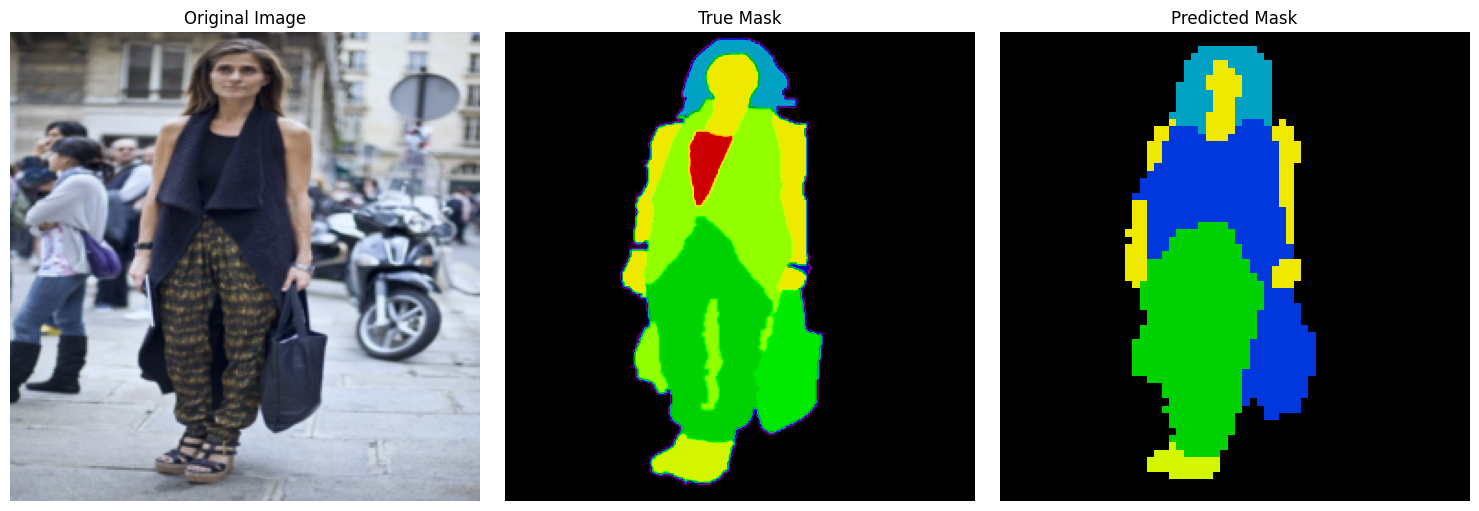

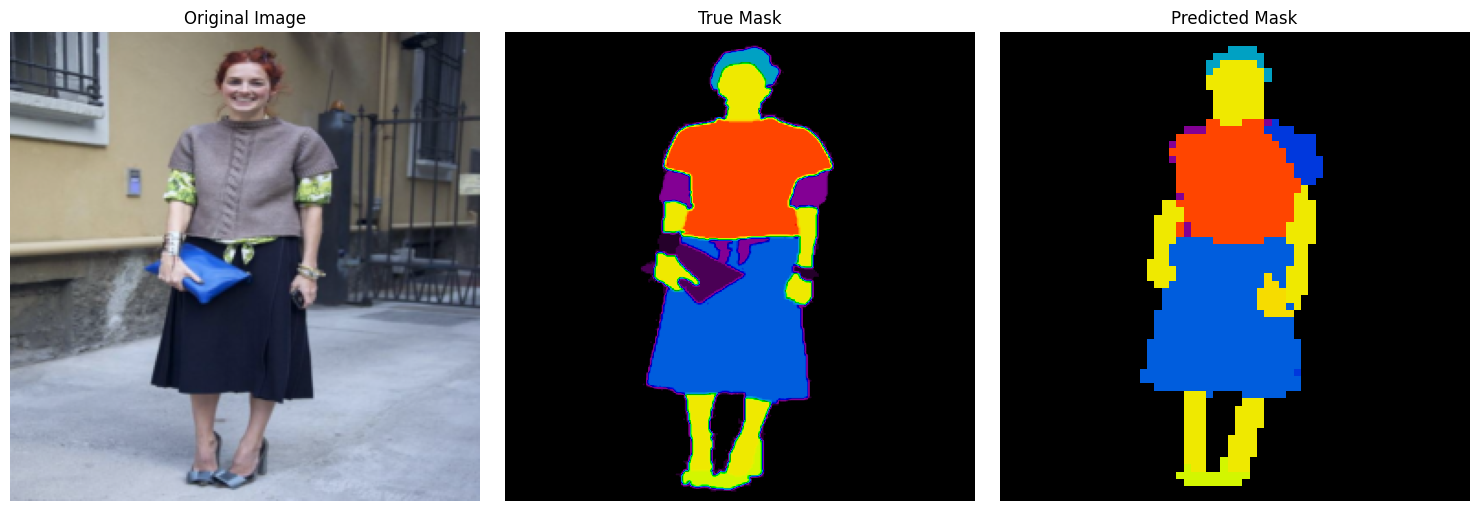

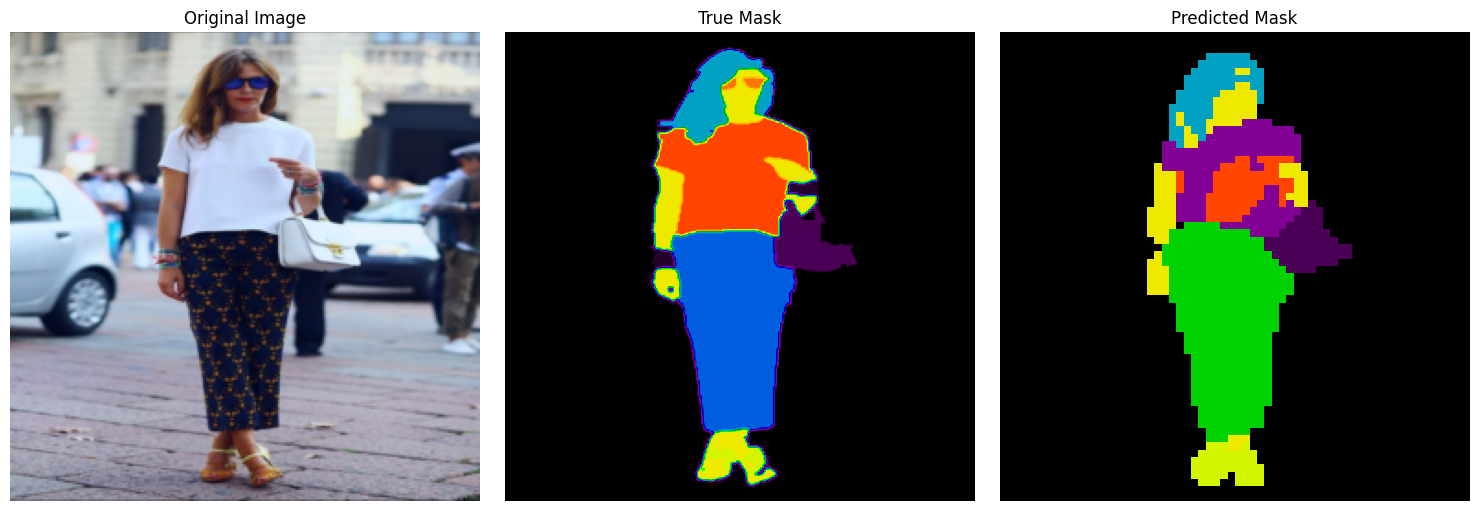

In [ ]:
def visualize_predictions(model, dataset, indices, processor):
    model.eval()
    for idx in indices:
        pixel_values, labels = dataset[idx]
        pixel_values = pixel_values.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            preds = outputs.logits.argmax(dim=1).squeeze(0).cpu().numpy()

        image = pixel_values.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image = (image - image.min()) / (image.max() - image.min())  

        true_mask = labels.squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(true_mask, cmap="nipy_spectral", vmin=0, vmax=59)
        axes[1].set_title("True Mask")
        axes[1].axis("off")

        axes[2].imshow(preds, cmap="nipy_spectral", vmin=0, vmax=59)
        axes[2].set_title("Predicted Mask")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

visualize_predictions(model, val_dataset, indices=[0, 10, -1], processor=processor)